In [2]:
import sys
sys.path.insert(0, '5_uncertainty_testing/SBDynT/src')
import sbdynt as sbd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.jplsbdb import SBDB
from pathlib import Path

import rebound as rb
import celmech as cm
import assist

from linear_theory import linear_theory_prediction, make_simpler_secular_theory
from utils import ecliptic_to_icrf, icrf_to_ecliptic, ecliptic_xyz_to_elements

Searching NASA Horizons for 'sun'... 
Found: Sun (10) 


In [3]:
ephem = assist.Ephem("data/assist/linux_m13000p17000.441", "data/assist/sb441-n16.bsp")
nesvorny_data = pd.read_csv("data/nesvorny_catalog_dataset.csv")
prediction_path = Path("data/calc_propa")
prediction_path.mkdir(parents=True, exist_ok=True)

/tmp/ipykernel_10190/3730445920.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  nesvorny_data = pd.read_csv("data/nesvorny_catalog_dataset.csv")


# Example Code for integrating backwards

In [4]:
# Get two example asteroids to test 
des = ['K15Bz3T', 'K08GG6Z']
epoch_n = 2460200.5 # Nesvorny epoch
epoch= 2460400.5 # the epoch your data is at
conver = 58.132440867049

In [5]:
sim = rb.Simulation()
sim.add(des[0], date = "JD%f"%epoch)
p = sim.particles[-1]
df1 = []
df1.append({
	"Des'n": des[0],
	"epoch": epoch,
	"x": p.x, 
	"y": p.y, 
	"z": p.z, 
	"vx": p.vx, 
	"vy": p.vy, 
	"vz": p.vz
})

df_e = pd.DataFrame(df1)
df_e

Searching NASA Horizons for 'K15Bz3T'... 
Found: 802375 (2015 BT613) 


/home/lshen/workspace/rebound/rebound/horizons.py:184: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


,Des'n,epoch,x,y,z,vx,vy,vz
0,K15Bz3T,2460400.5,1.34214,2.68696,-0.287471,-0.48894,0.294011,0.071579


In [6]:
# Convert orbital elements in xyz, vxvyvz
ast = df_e.iloc[0]
sim = rb.Simulation()
sim.add("Sun", date = "JD%f"%epoch)
sim.add(x = ast["x"].item(),
        y = ast["y"].item(),
        z = ast["z"].item(),
        vx = ast["vx"].item()/conver,
    	vy = ast["vy"].item()/conver,
        vz = ast["vz"].item()/conver,
        date = "JD%f"%epoch)
p = sim.particles[1]
print(p.xyz, p.vxyz)
# Rotate to icrf
p = ecliptic_to_icrf(p)
print(p.xyz, p.vxyz)
# Use ASSIST to integrate backwards to Nesvorny epoch
sim_a = rb.Simulation()
ex = assist.Extras(sim_a, ephem)
ex.gr_eih_sources = 11
sim_a.t = epoch - ephem.jd_ref
sim_a.ri_ias15.adaptive_mode = 2
sim_a.add(p, plane = "frame", date="JD%f"%epoch)
sim_a.add(ast["Des'n"], plane = "frame", date="JD%f"%epoch)
print(sim_a.particles[-2].vxyz, sim_a.particles[-1].vxyz)
sim_a.move_to_com()
sim_a.exit_max_distance = 50.0
ex.integrate_or_interpolate(epoch_n - ephem.jd_ref)
p = sim_a.particles[-1]
p = icrf_to_ecliptic(p)
p.vxyz = np.array(p.vxyz) * conver

# Retrieve the orbital elements
orbit = ecliptic_xyz_to_elements(p)
print(orbit)

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
[1.342139834380178, 2.6869603125265153, -0.2874707110867167] [-0.008410792463063699, 0.005057611021157758, 0.0012313044191130489]
[1.342139834380178, 2.5795871701202917, 0.8050622103763636] [-0.008410792463063699, 0.004150482618975376, 0.0031415018452082824]
Searching NASA Horizons for 'K15Bz3T'... 


/home/lshen/workspace/rebound/rebound/simulation.py:927: RuntimeWarning: Particle is being adding from a simulation that uses different units.
  warnings.warn("Particle is being adding from a simulation that uses different units.", RuntimeWarning)


Found: 802375 (2015 BT613) 
[-0.008410792463063699, 0.004150482618975376, 0.0031415018452082824] [-0.008410792463063704, 0.004150482618914457, 0.003141501845288773]
<rebound.Orbit instance, a=3.0273227871095423 e=0.06284916807480725 inc=0.16222429428363397 Omega=1.730207813064412 omega=4.042970809565853 f=0.928587625322324>


/home/lshen/workspace/rebound/rebound/horizons.py:184: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


In [7]:
data = nesvorny_data[nesvorny_data["Des'n"] == 'K15Bz3T'][["a", "e", "Incl.", "Node", "Peri."]]
data["Incl."] = data["Incl."] * np.pi/180
data["Node"] = data["Node"] * np.pi/180
data["Peri."] = data["Peri."] * np.pi/180
data

,a,e,Incl.,Node,Peri.
901219,3.027323,0.062849,0.162224,1.730208,4.042971


# Proper a integration

In [8]:
from multiprocessing import Pool
from pathlib import Path
from tqdm import tqdm
from itertools import islice

import pandas as pd
import numpy as np

import rebound as rb
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import assist
# %%
model_results = pd.read_csv("data/model_results.csv", index_col=0, dtype={"Des'n": str})

prediction_path = Path("data/calc_propa")
prediction_path.mkdir(parents=True, exist_ok=True)
ephem = assist.Ephem("data/assist/linux_m13000p17000.441", "data/assist/sb441-n16.bsp")

In [47]:
list = nesvorny_data[nesvorny_data["Des'n"] == 'K22SH4P']
sim = rb.Simulation()
sim.add("Sun", date = "JD%f"%epoch_n)
sim.add(primary=sim.particles[0], a=list['a'].item(), e=list['e'].item(), inc=list['Incl.'].item()*np.pi/180, Omega=list['Node'].item()*np.pi/180, omega=list['Peri.'].item()*np.pi/180, M=list['M'].item()*np.pi/180)
sim.particles[1].xyz
p = ecliptic_to_icrf(sim.particles[1])
sim.particles[1].orbit(primary = sim.particles[0], G=1).a

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 


2.550384379745512

In [44]:
object_name = 'K22SH4P'
sim = rb.Simulation()
# ex = assist.Extras(sim, ephem)
sim.add("Sun", date = "JD%f"%epoch_n, plane = "frame")
sim.add(object_name, date="JD%f"%epoch_n, plane = "frame")
sim.t = epoch - ephem.jd_ref
sim.ri_ias15.adaptive_mode = 2
sim.particles[1].orbit(primary = sim.particles[0], G=1).a

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'K22SH4P'... 
Found: (2022 SP174) 


/home/lshen/workspace/rebound/rebound/horizons.py:184: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


2.5507862448867114

In [17]:
object_name = 'K22SH4P'
sim = rb.Simulation()
ex = assist.Extras(sim, ephem)
sim.add("Sun", date = "JD%f"%epoch_n, plane = "frame")
sim.add(object_name, date="JD%f"%epoch_n, plane = "frame")
sim.t = epoch - ephem.jd_ref
sim.ri_ias15.adaptive_mode = 2
sim.particles[1].a, sim.particles[1].vxyz

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'K22SH4P'... 
Found: (2022 SP174) 


/home/lshen/workspace/rebound/rebound/horizons.py:184: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


(2.550786244886712, [-0.009083014032459303, -0.003340894018343768, -0.00031910 ↪

↪ 930309418786])

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
K22SH4P
Searching NASA Horizons for 'sun'... 
Found: Sun (10) 
('K22SH4P', np.float64(2.5511444047650644))


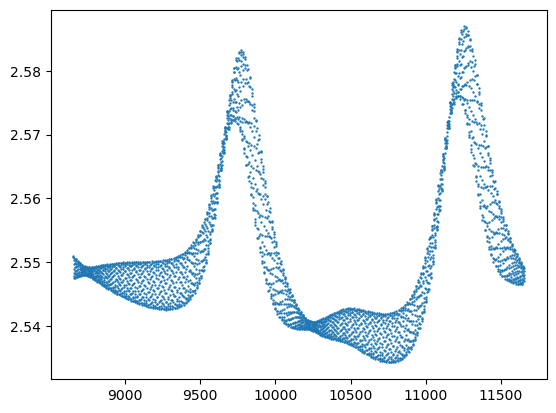

In [69]:
sun_sim = rb.Simulation()
sun_sim.add("Sun", date = "JD%f"%epoch_n, plane = "frame")
sun = sun_sim.particles[-1]
def propa_calc(r):
	idx, row = r
	epoch = 2460200.5
	print(row["Des'n"])
	# Convert Nesvorny orbital elements into xyz, vxyz
	sim = rb.Simulation()
	sim.add("sun", date = "JD%f"%epoch, plane = "ecliptic")
	ps = sim.particles
	sim.add(primary=ps[0], 
		 a=row['a'], 
		 e=row['e'], 
		 inc=row['Incl.']*np.pi/180, 
		 Omega=row['Node']*np.pi/180, 
		 omega=row['Peri.']*np.pi/180, 
		 M=row['M']*np.pi/180)
	p = sim.particles[-1]
	p = ecliptic_to_icrf(sim.particles[-1])
	p.vxyz = np.array(p.vxyz) / conver

	# ASSIST integration
	Nout = int(1e3*np.pi)
	sim = rb.Simulation()
	ex = assist.Extras(sim, ephem)
	sim.t = epoch - ephem.jd_ref
	sim.ri_ias15.adaptive_mode = 2
	sim.add(p)
	sim.dt = 1
	p = icrf_to_ecliptic(p)
	orb = ecliptic_xyz_to_elements(p)
	times = np.linspace(sim.t, 3e3 + sim.t, Nout)
	a = np.zeros(Nout)
	for i, time in enumerate(times):
		sim.integrate(time)
		p = sim.particles[-1]
		p = icrf_to_ecliptic(p)
		p.vxyz = np.array(p.vxyz) * conver
		orbit = ecliptic_xyz_to_elements(p)
		p.vxyz = np.array(p.vxyz) / conver
		a[i] = orbit.a
	
	plt.scatter(times, a, s = 0.5)
	return row["Des'n"], np.mean(a)
	

r = propa_calc(next(model_results.iterrows()))
print(r)

In [42]:
nesvorny_data[nesvorny_data["Des'n"] == 'K22SH4P'][["a", "propa"]]

,a,propa
1225043,2.55078,2.553547
